In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [117]:
import tensorflow as tf
print(tf.__version__)


2.15.0


#### Read the data

In [118]:
sales_data = pd.read_csv("data_set/train.csv")

sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### check for null values

In [119]:
sales_data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [120]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


#### Dropping store and Item coloumns

In [121]:
sales_data = sales_data.drop(['store', 'item'], axis=1)

sales_data.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [122]:
sales_data['date'].dtype

dtype('O')

#### convert date to date format

In [123]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [124]:
sales_data.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


#### converting date to a Month period and then sum the number of items in each month

In [125]:
sales_data['date'] = sales_data['date'].dt.to_period("M")

monthly_sales = sales_data.groupby('date').sum().reset_index()

monthly_sales.head()

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


#### converting the resulting date column to timestamp datatype

In [126]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


#### Visualize the monthly sales

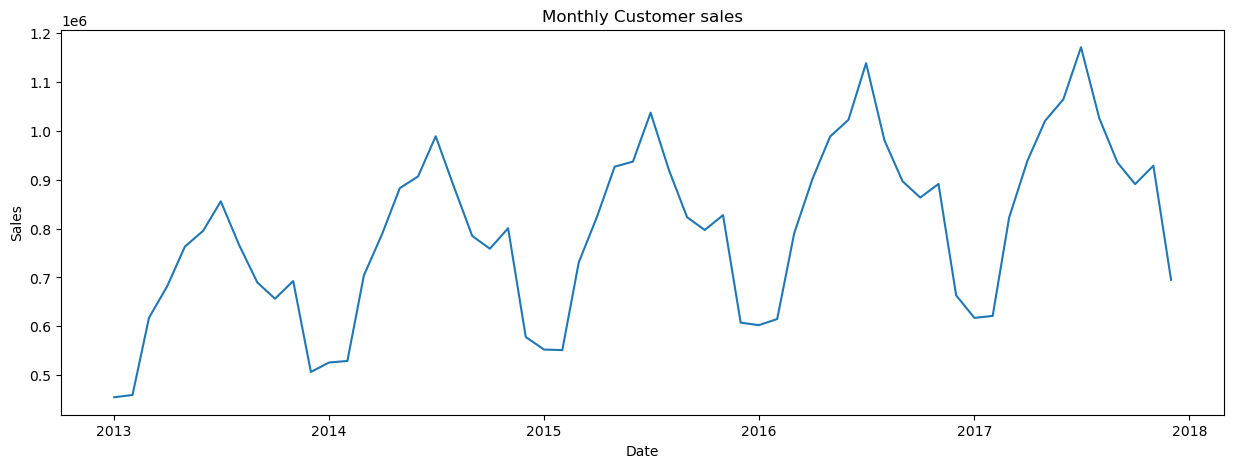

In [127]:
plt.figure(figsize=(15,5))

plt.plot(monthly_sales['date'], monthly_sales['sales'])

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer sales")
plt.show()

#### call the difference on the sales coloumns to make the sales data stationery

In [128]:
""" The .diff() method calculates the difference between each row and the previous row in the sales column. """

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()

monthly_sales.head(20)



,date,sales,sales_diff
0,2013-01-01,454904,NaN
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0


In [129]:
monthly_sales = monthly_sales.dropna()

monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


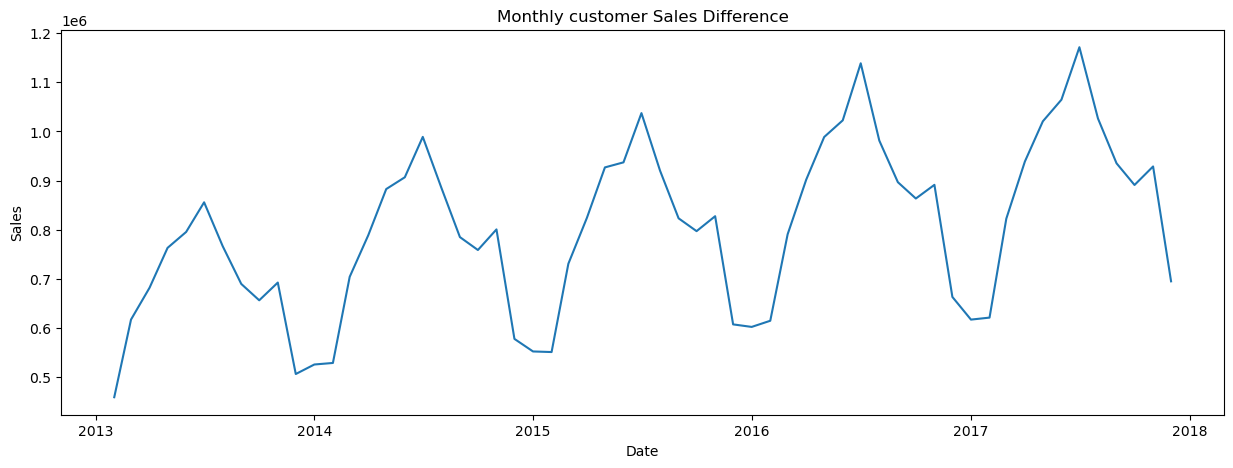

In [130]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")

plt.title("Monthly customer Sales Difference")
plt.show()


#### create data for supervised learning

In [131]:
supervised_data = monthly_sales.drop(['date','sales'], axis=1)

supervised_data.head()

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0


#### Preparing the supervised data

In [132]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)

supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


#### split data into training and test data

In [133]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

print("Train Data Shape", train_data.shape )
print("Test Data Shape", test_data.shape )

Train Data Shape (35, 13)
Test Data Shape (12, 13)


#### sclaing min max

In [134]:
# Initializing a MinMaxScaler to scale the features to a range between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1))

# Fitting the scaler on the training data only to prevent data leakage from the test set
scaler.fit(train_data)

# Transforming both the training and testing data with the scaler
# This scales the features in both datasets to the range [-1, 1]
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [135]:
# Splitting the training data into features and labels
x_train, y_train = train_data[:,1:], train_data[:,0:1]  # Extracting features and labels for the training data
# Explanation:
# train_data[:,1:]: Takes all rows and all columns starting from the second column as features (inputs) for training.
# train_data[:,0:1]: Takes all rows and only the first column as the label (target) for training, maintaining a 2D array structure.

# Splitting the test data into features and labels (corrected version)
x_test, y_test = test_data[:,1:], test_data[:,0:1]  # Extracting features and labels for the test data
# Explanation:
# test_data[:,1:]: Takes all rows and all columns starting from the second column as features (inputs) for testing.
# test_data[:,0:1]: Takes all rows and only the first column as the label (target) for testing, ensuring a 2D array structure.

In [136]:
y_train = y_train.ravel()  # Convert the 2D y_train array into a 1D array
y_test = y_test.ravel()    # Convert the 2D y_test array into a 1D array


print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (35, 12)
y_train shape (35,)
x_test shape (12, 12)
y_test shape (12,)


#### Make prediction data frame to merger the predicited sale prices of all trained algorithims

In [137]:

# Select the last 12 months' dates from the monthly_sales DataFrame, reset the index without adding the old index as a column, and store it in sales_dates.
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)

predict_df = pd.DataFrame(sales_dates)

In [138]:
# Extract the sales data for the last 13 months from the monthly_sales DataFrame and convert this data into a list. The selection of 13 months (instead of 12) could be for reasons such as including a baseline month for comparison in analyses.

act_sales = monthly_sales['sales'][-13:].to_list()

print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


#### linear Regression model and predicted output

In [139]:
# Instantiate the LinearRegression model
lr_model = LinearRegression()

# Fit the model on the training dataset
# x_train contains the feature(s), and y_train contains the target variable
lr_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test dataset
# x_test contains the new or unseen feature(s) for which we want to predict the target variable
lr_pre = lr_model.predict(x_test)


In [140]:
# Reshape the predictions to make it a 2D array compatible for concatenation
lr_pre = lr_pre.reshape(-1,1)

# Concatenate the predictions with the original test features
# This is necessary because the scaler expects the same number of features as the input data
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)

# Inverse transform the concatenated set to revert the scaling operation
# This brings the predictions and features back to their original scale
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)


In [141]:
# Initialize an empty list to store the final results after adjustments
result_list = []

# Iterate through each prediction made by the linear regression model
for index in range(0, len(lr_pre_test_set)):
    # Adjust each prediction by adding it to the actual sales from the previous period
    # This step is crucial for transforming the predictions back to their original scale
    # and aligning them with the actual sales data for comparison
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])

# Convert the list of adjusted predictions into a pandas Series for easier manipulation
# and give it a name for identification
lr_pre_series = pd.Series(result_list, name="Liner Prediction")

# Merge the series of adjusted predictions with the dataframe containing dates
# This aligns each prediction with its corresponding date, facilitating a direct comparison
# between predicted sales and actual sales over time
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

print(predict_df)

         date  Liner Prediction
0  2017-01-01      6.479148e+05
1  2017-02-01      6.283374e+05
2  2017-03-01      8.195190e+05
3  2017-04-01      9.436391e+05
4  2017-05-01      1.033653e+06
5  2017-06-01      1.065286e+06
6  2017-07-01      1.201561e+06
7  2017-08-01      1.002123e+06
8  2017-09-01      9.415142e+05
9  2017-10-01      9.080646e+05
10 2017-11-01      9.167461e+05
11 2017-12-01      6.947978e+05


#### Evalution metrics

In [142]:


lr_rmse = np.sqrt(mean_squared_error(predict_df['Liner Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Liner Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Liner Prediction'], monthly_sales['sales'][-12:])


print("LinearRegression rmse: ", lr_rmse)
print("LinearRegression MAE: ", lr_mae)
print("LinearRegression R2: ", lr_r2)

LinearRegression rmse:  16221.27238541688
LinearRegression MAE:  12433.184266490745
LinearRegression R2:  0.9906152516380969


#### Visualization of the prediction against the actual sales

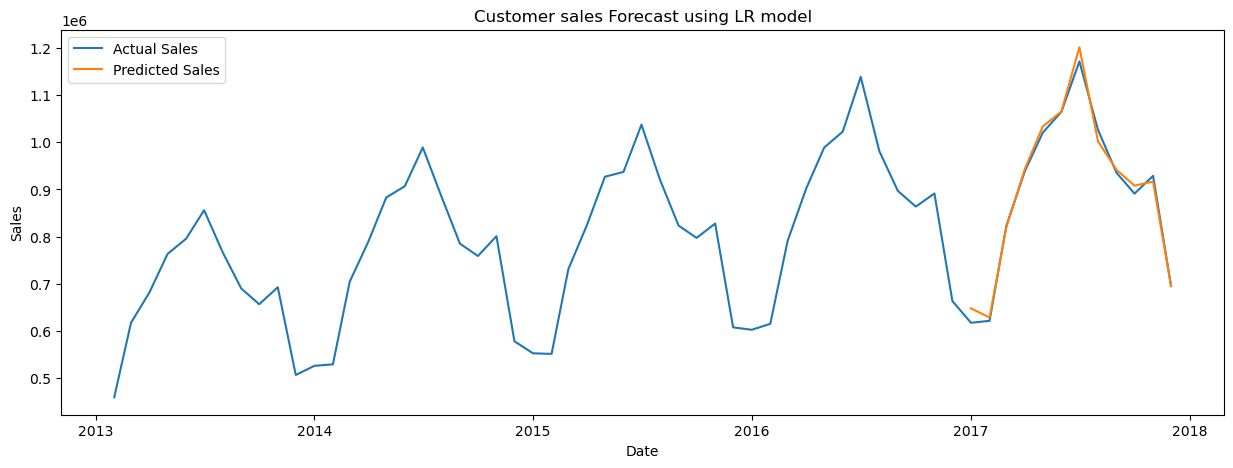

In [143]:
plt.figure(figsize=(15,5))

# actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])

# predicted sales
plt.plot(predict_df['date'], predict_df['Liner Prediction'])

plt.title("Customer sales Forecast using LR model")

plt.xlabel("Date")
plt.ylabel("Sales")

plt.legend(['Actual Sales', 'Predicted Sales'])


plt.show()